# NASNET 2 Class

In [2]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from keras import backend as K
from keras.utils import multi_gpu_model
from sklearn.utils import compute_class_weight

In [3]:
# dimensions of our images.
img_width, img_height = 224, 224

train_data_dir = '../dataset/train'
validation_data_dir = '../dataset/test'
classes = ['N', 'V']
epochs = 50
batch_size = 4

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)


In [4]:
from keras.applications.nasnet import NASNetMobile

import numpy as np
base_model = NASNetMobile(weights='imagenet', input_shape=(img_width, img_height, 3), pooling = 'avg', include_top = False)

#adam = keras.optimizers.Adam(lr=1e-4)
#model.compile(loss='binary_crossentropy',
#              optimizer=adam,
#              metrics=['accuracy'])

x = base_model.output
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


adam = keras.optimizers.Adam()
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])











Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    samplewise_center=True,
    samplewise_std_normalization=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255, samplewise_center=True,
    samplewise_std_normalization=True,)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    classes=classes,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    classes=classes,
    class_mode='binary')

nb_train_samples = train_generator.n
nb_validation_samples = validation_generator.n

class_weights = compute_class_weight("balanced", np.unique(train_generator.classes), train_generator.classes)
class_weights

Found 351 images belonging to 2 classes.
Found 85 images belonging to 2 classes.


array([0.90463918, 1.11783439])

In [6]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, verbose=1, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)

cb_list = [early_stop, reduce_lr]

In [7]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    class_weight = class_weights,
    callbacks = cb_list)

Epoch 1/50
87/87 [==============================] - 104s 1s/step - loss: 1.1699 - acc: 0.5402 - val_loss: 1.0591 - val_acc: 0.5952
Epoch 2/50
87/87 [==============================] - 44s 510ms/step - loss: 0.7659 - acc: 0.5910 - val_loss: 0.8888 - val_acc: 0.6173
Epoch 3/50
87/87 [==============================] - 44s 503ms/step - loss: 0.6385 - acc: 0.6695 - val_loss: 2.4389 - val_acc: 0.5432
Epoch 4/50
87/87 [==============================] - 37s 422ms/step - loss: 0.7051 - acc: 0.6169 - val_loss: 1.7170 - val_acc: 0.4444

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/50
87/87 [==============================] - 36s 414ms/step - loss: 0.5383 - acc: 0.7414 - val_loss: 1.0483 - val_acc: 0.5185
Epoch 6/50
87/87 [==============================] - 36s 413ms/step - loss: 0.5245 - acc: 0.7442 - val_loss: 1.2683 - val_acc: 0.5185
Restoring model weights from the end of the best epoch

Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.0000000

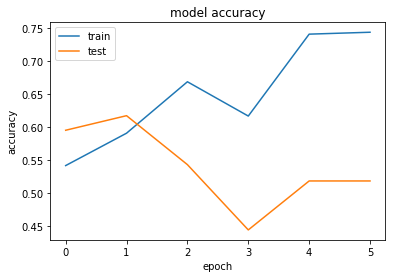

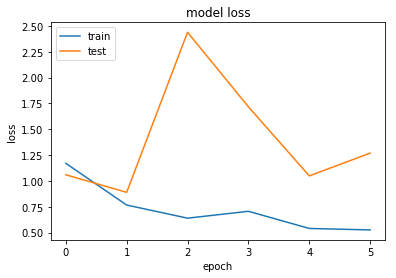

In [8]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
y_pred = []
y_true = []
for i in range(nb_validation_samples // batch_size):
    x, y = next(validation_generator)
    y_true.extend(y)
    y_pred.extend(np.round(model.predict(x)))

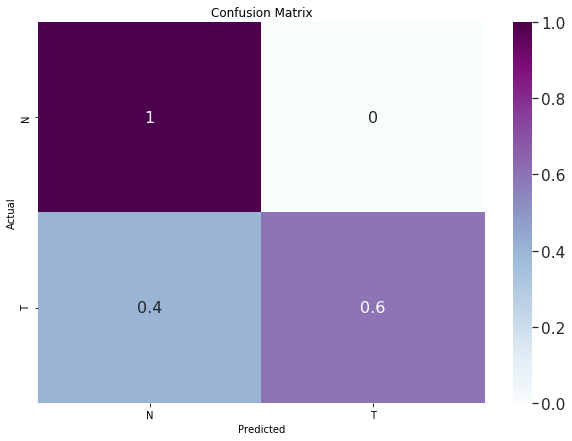

In [9]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

data = confusion_matrix(y_true, y_pred)
data = data / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
plt.title("Confusion Matrix")
labels = ['N', 'T']
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="BuPu", annot=True,xticklabels = labels, yticklabels =labels, annot_kws={"size": 16})# font size

In [17]:
# Get some data for shapping
background_datagen = ImageDataGenerator(rescale=1. / 255, samplewise_center=True,
    samplewise_std_normalization=True,)
sample_datagen = ImageDataGenerator(rescale=1. / 255, samplewise_center=True,
    samplewise_std_normalization=True,)

shap_background_generator = background_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=50,
    classes=classes,
    class_mode='binary')

shap_sample_generator = sample_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=50,
    classes=classes,
    class_mode='binary')

Found 208 images belonging to 2 classes.
Found 52 images belonging to 2 classes.


In [18]:
import shap

x_train, _ = next(shap_background_generator)
x_test, _ = next(shap_sample_generator)
print(x_train.shape, x_test.shape)

# select a set of background examples to take an expectation over
background = x_train #[np.random.choice(x_train.shape[0], 10, replace=True)]

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly

(50, 224, 224, 3) (50, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1440x1440 with 0 Axes>

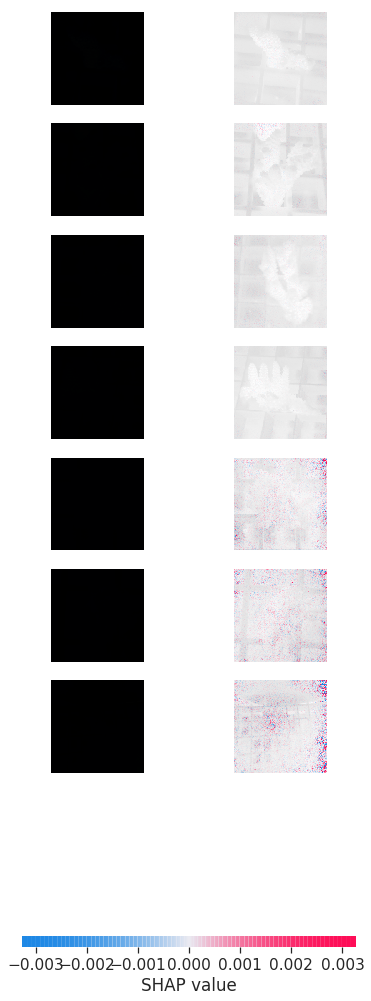

In [39]:
good_idxs = [0, 40, 45, 20, 3, 19, 29]
plt.figure(figsize=(20, 20))
shap_values = e.shap_values(x_test[good_idxs])
shap.image_plot(shap_values, -x_test[good_idxs])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


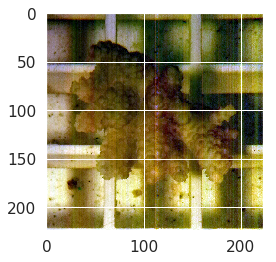

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


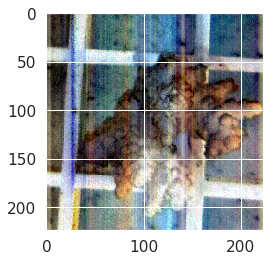

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


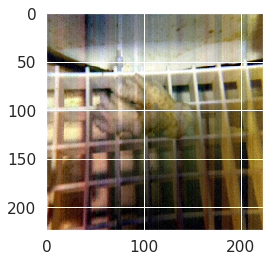

In [33]:
from sklearn.preprocessing import MinMaxScaler

for idx in good_idxs:
    scaler = MinMaxScaler()
    data = x_test[idx]
    og_shape = data.shape
    plt.figure()
    plt.imshow(scaler.fit_transform(data.reshape((data.shape[0], -1))).reshape(og_shape))
    plt.show()

In [29]:
x_test.shape

(50, 224, 224, 3)